In [27]:
import os
import torch
from PIL import Image
import torch.nn as nn
from tqdm import tqdm
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from torchvision.models import MobileNet_V3_Small_Weights
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

class SimpsonsTestDataset(torch.utils.data.Dataset):
    def __init__(self, test_dir, transform=None, class_to_idx=None):
        self.test_dir = test_dir
        self.transform = transform
        self.class_to_idx = class_to_idx
        self.image_paths = [os.path.join(test_dir, fname) for fname in os.listdir(test_dir)]
        self.labels = [self.class_to_idx[fname.rsplit("_", 1)[0]] for fname in os.listdir(test_dir)]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Device: {device}")

train_dir = "TheSimpsons/DataSet/"
test_dir = "TheSimpsons/TestSet/"

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = ImageFolder(root=train_dir, transform=train_transform)
class_to_idx = train_dataset.class_to_idx
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])
val_dataset.dataset.transform = test_transform

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)
test_dataset = SimpsonsTestDataset(test_dir, transform=test_transform, class_to_idx=class_to_idx)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

mobilenet = models.mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.DEFAULT).to(device)
num_features = mobilenet.classifier[3].in_features
mobilenet.classifier[3] = nn.Linear(num_features, len(class_to_idx)).to(device)

Device: mps


In [28]:
def draw_plots(train_losses, val_losses, train_accs, val_accs):
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid()
    plt.show()
    
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_accs) + 1), train_accs, label='Train Accuracy')
    plt.plot(range(1, len(val_accs) + 1), val_accs, label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid()
    plt.show()

Epoch 1/1: 100%|██████████| 524/524 [01:03<00:00,  8.27it/s]


Epoch 1: Train Loss 0.6031, Val Loss 0.4104, Train Acc 0.8437, Val Acc 0.8889
Better weights saved


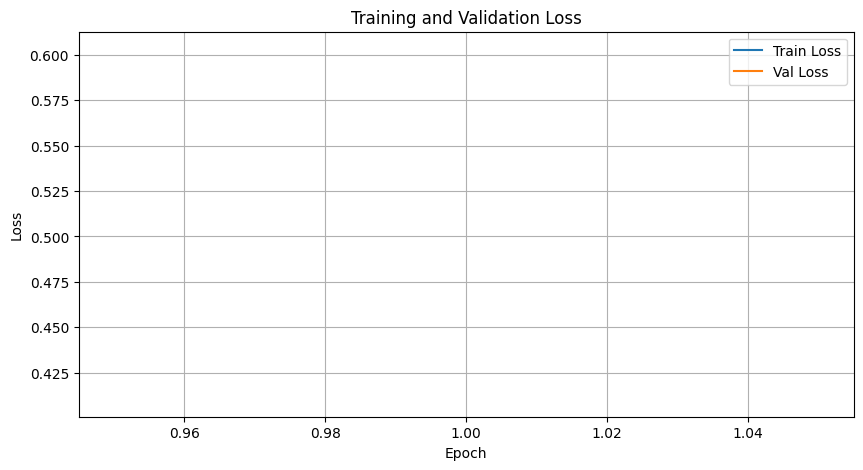

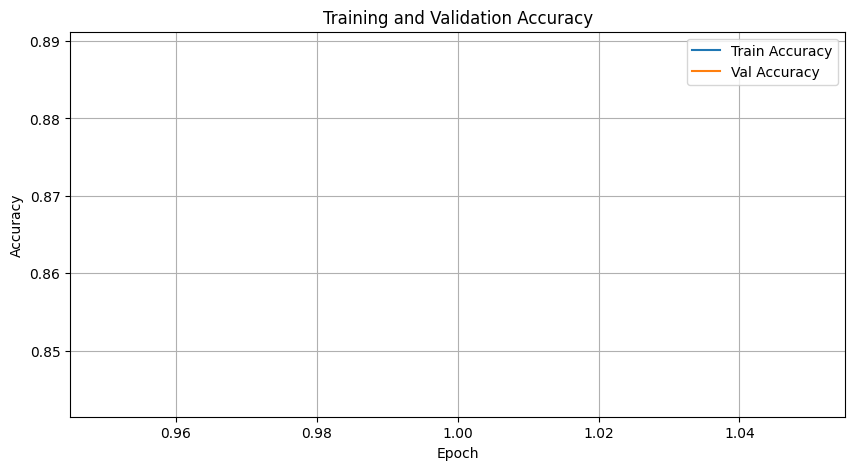

In [29]:
def evaluate(model, loader, criterion, return_metrics=False):
    model.eval()
    all_preds = []
    all_labels = []
    total_loss = 0.0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = outputs.max(1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = sum(p == l for p, l in zip(all_preds, all_labels)) / len(all_labels)
    avg_loss = total_loss / len(loader)
    
    if return_metrics:
        precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
        recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
        f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
        return accuracy, avg_loss, precision, recall, f1
    return accuracy, avg_loss

def train_model(model, criterion, optimizer, train_loader, val_loader, epochs=10, pr=3):
    model.train()
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    best_loss = float('inf') 
    no_progress = 0 

    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs}", colour="green"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total
        train_loss = running_loss / len(train_loader)
        val_acc, val_loss = evaluate(model, val_loader, criterion) 
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        
        print(f"Epoch {epoch+1}: Train Loss {train_loss:.4f}, Val Loss {val_loss:.4f}, "f"Train Acc {train_acc:.4f}, Val Acc {val_acc:.4f}")
        
        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), "best_weights.pth")
            print("Better weights saved")
            no_progress = 0
        else:
            no_progress += 1
            print("No progress")
            if no_progress >= pr:
                print("Early stop")
                break
    
    draw_plots(train_losses, val_losses, train_accs, val_accs)
    return model

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mobilenet.parameters(), lr=0.001)

trained_model = train_model(mobilenet, criterion, optimizer, train_loader, val_loader, epochs=1)

In [31]:
mobilenet.load_state_dict(torch.load("best_weights.pth"))

print("Testing...")
test_acc, test_loss, precision, recall, f1 = evaluate(mobilenet, test_loader, criterion, return_metrics=True)
print(f"Loss: {test_loss:.4f}")
print(f"Accuracy: {test_acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

Testing...
Loss: 0.2293
Accuracy: 0.9384
Precision: 0.9522
Recall: 0.9384
F1-score: 0.9420
